# Import

In [3]:
import pandas as pd
from psaw import PushshiftAPI
import datetime as dt
from tqdm import tqdm
import numpy as np
import warnings
import analysis_util
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
warnings.filterwarnings("ignore")
from scipy.stats import pearsonr

# Data

In [19]:
df=pd.read_csv('/home/pelle/Master_Thesis/data/processed/community_metrics.csv').sort_values('number_of_nodes',ascending=False)
# convert to int in days mean_delta_time
df['mean_delta_time']=df['mean_delta_time'].apply(lambda x: int(x[:3]))

# remove old versions of each subrredit
def remove_old_versions(df):
    df=df.sort_values('version')
    df=df.drop_duplicates(subset=['subreddit'],keep='last')
    return df

df=remove_old_versions(df)
df.head(20)

,subreddit,version,period,total_activity,number_of_nodes,number_of_edges,average_weight_of_edges,median_weight_of_edges,average_degree,median_degree,average_clustering_coefficient,mean_activity,mean_delta_time,number_of_reciprocal_edges,fraction_of_reciprocal_edges,clustering_coefficient_p_value
9,FourSentenceStories,2022-11-18 10:14:18,2021-05-04 - 2021-12-28,200,34,28,2.678571,1.0,1.647059,1.0,0.274683,5.823529,19,15,0.428571,0.023
10,Trump666,2022-11-18 10:15:23,2020-03-16 - 2022-01-01,6746,755,1628,2.652948,1.0,4.312583,2.0,0.202507,7.909934,53,1048,0.492944,0.000
11,GraphTheory,2022-11-18 10:18:32,2015-02-17 - 2021-12-26,497,247,163,1.717791,1.0,1.319838,1.0,0.015602,2.012146,59,124,0.563636,0.286
12,jazznoir,2022-11-18 10:19:14,2015-01-01 - 2022-01-01,4725,1497,1139,1.474100,1.0,1.521710,1.0,0.009824,2.985944,122,640,0.453258,0.016
13,indoorbouldering,2022-11-18 11:16:58,2017-08-23 - 2022-01-01,10532,2529,4866,1.665228,1.0,3.848161,2.0,0.061709,3.967181,112,3487,0.531960,0.000
14,DTU,2022-11-18 11:22:59,2015-05-15 - 2022-01-01,2788,689,1196,1.805184,1.0,3.471698,2.0,0.064316,4.046444,136,1014,0.600355,0.000
15,kiwi_bird,2022-11-18 11:24:00,2015-02-21 - 2021-12-27,862,302,301,1.594684,1.0,1.993377,1.0,0.047712,2.778146,65,128,0.357542,0.085


In [3]:
df.rename(columns={'mean_delta_time':'$\overline{\D t}$'},inplace=True)
df.rename(columns={'number_of_nodes':'$N$'},inplace=True)
df.rename(columns={'number_of_edges':'$E$'},inplace=True)
df.rename(columns={'total_activity': '$A$'},inplace=True)
df.rename(columns={'mean_activity': '$\overline{A}$'},inplace=True)
df.rename(columns={'mean_degree': '$\overline{D}$'},inplace=True)
df.rename(columns={'median_degree': '$D_{\mu}$'},inplace=True)
df.rename(columns={'average_clustering_coefficient': '$\overline{C}$'},inplace=True)
df.rename(columns={'average_weight_of_edges': '$\overline{W}$'},inplace=True)
df.rename(columns={'median_weight_oaverage_degreef_edges': '$W_{\mu}$'},inplace=True)
df.rename(columns={'average_degree': '$\overline{D}$'},inplace=True)
df.rename(columns={'number_of_reciprocal_edges': '$R$'},inplace=True)
df.rename(columns={'fraction_of_reciprocal_edges': '$R_{\%}$'},inplace=True)
df.rename(columns={'clustering_coefficient_p_value': '$P_{C}$'},inplace=True)
df.rename(columns={'median_weight_of_edges': '$W_{\mu}$'},inplace=True)

print(df.drop(columns=['version']).round(decimals=3).to_latex(escape=False,index=False))

\begin{tabular}{llrrrrrrrrrrrrr}
\toprule
          subreddit &                period &   $A$ &  $N$ &  $E$ &  $\overline{W}$ &  $W_{\mu}$ &  $\overline{D}$ &  $D_{\mu}$ &  $\overline{C}$ &  $\overline{A}$ &  $\overline{\D t}$ &  $R$ &  $R_{\%}$ &  $P_{C}$ \\
\midrule
   indoorbouldering & 2015-01-01-2022-01-01 & 11653 & 2529 & 4866 &           1.665 &        1.0 &           3.848 &        2.0 &           0.062 &           3.967 &                112 & 3487 &     0.532 &    0.000 \\
           jazznoir & 2015-01-01-2022-01-01 &  7077 & 1497 & 1139 &           1.474 &        1.0 &           1.522 &        1.0 &           0.010 &           2.986 &                122 &  640 &     0.453 &    0.012 \\
           Trump666 & 2015-01-01-2022-01-01 &  7102 &  755 & 1628 &           2.653 &        1.0 &           4.313 &        2.0 &           0.203 &           7.910 &                 53 & 1048 &     0.493 &    0.000 \\
                DTU & 2015-01-01-2022-01-01 &  3274 &  689 & 1196 &          

In [16]:
df_explanation=pd.DataFrame(df['subreddit']).set_index('subreddit')

# df_explanation['DTU']['xx']

# new collumns for explanation
df_explanation['explanation']=0
df_explanation['explanation']['DTU'] = "A subreddit related to the technical university of Denmark DTU"
df_explanation['explanation']['jazznoir'] = ""


df_explanation

,explanation
subreddit,
indoorbouldering,0
jazznoir,0
Trump666,0
DTU,"A research university in Denmark, with a focus..."
kiwi_bird,0
GraphTheory,0
FourSentenceStories,0


In [3]:
# rho = df.corr()
# pval = df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
# p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))

# fig, ax = plt.subplots(figsize=(14,14))

# sns.heatmap(data=rho, annot=(np.array(rho.round(2).astype(str) + p)),fmt = '',vmin=-1,vmax=1,cmap='coolwarm')

# # rotate xticks
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=12)
# ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
# plt.show()

In [5]:
# start = df_comments.created_utc.min()
# period = df_comments.created_utc.max()-df_comments.created_utc.min()
# step = dt.timedelta(weeks=10)

# graph_dict = {}

# for i in tqdm(range(int(np.ceil(period / step)))):
#     before = start + step*i + step
#     # df_comments_before=df_comments.loc[df_comments.created_utc<before]
    
#     # G = nx.Graph()
#     # G.add_edges_from(df_comments_before[['author','parent_author']].dropna().values)
#     # # save graph as pickle to /home/pelle/Master_Thesis/data/processed/wallstreetbets_temporal_graphs
#     # nx.write_gpickle(G, '/home/pelle/Master_Thesis/data/processed/wallstreetbets_temporal_graphs/{}.gpickle'.format(before))

100%|██████████| 1/1 [00:00<00:00, 2741.38it/s]


In [11]:
# sample data to get dtypes
sample = pd.read_csv('/home/pelle/Downloads/comments_pmaw_2016-2021_wsb.csv',nrows=100)
dtypes = sample.dtypes # Get the dtypes
cols = sample.columns # Get the columns
dtype_dictionary = {} 
for c in cols:
    if str(dtypes[c]) == 'int64':
        dtype_dictionary[c] = 'float32' # Handle NANs in int columns
    else:
        dtype_dictionary[c] = str(dtypes[c])
dtype_dictionary['author'] = 'str'
dtype_dictionary['body'] = 'str'
dtype_dictionary['parent_id'] = 'str'
dtype_dictionary['link_id'] = 'str'
dtype_dictionary['id'] = 'str'


# read data
print('Reading data...')
df_comments_chunked = pd.read_csv('/home/pelle/Downloads/comments_pmaw_2016-2021_wsb.csv', dtype=dtype_dictionary, 
                 keep_default_na=False, 
                 error_bad_lines=False,
                 na_values=['na',''],
                 usecols=['author','parent_author','created_utc','score'],chunksize=1000000,nrows=10000)

df_comments = pd.concat(df_comments_chunked, ignore_index=True)
df_comments.created_utc = pd.to_datetime(df_comments.created_utc,unit='s')
print('Done reading!'+'\n')

df_posts = pd.read_csv('/home/pelle/Downloads/submissions_pmaw_2016-2021_wsb.csv',nrows=100)

Reading data...
Done reading!



/tmp/ipykernel_3006/251551527.py:20: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df_comments_chunked = pd.read_csv('/home/pelle/Downloads/comments_pmaw_2016-2021_wsb.csv', dtype=dtype_dictionary,


In [12]:
df_authors=pd.concat([df_posts[['author','score']],df_comments[['author','score']]])
s=df_authors.groupby('author').sum().rename(columns={'score':'sum_score'})
m=df_authors.groupby('author').mean().rename(columns={'score':'mean_score'})
df_score=s.join(m)

In [21]:
df_score.loc[next(iter(G.nodes())),'sum_score']

1946.0

In [18]:
next(iter(G.nodes()))

'theycallme1'

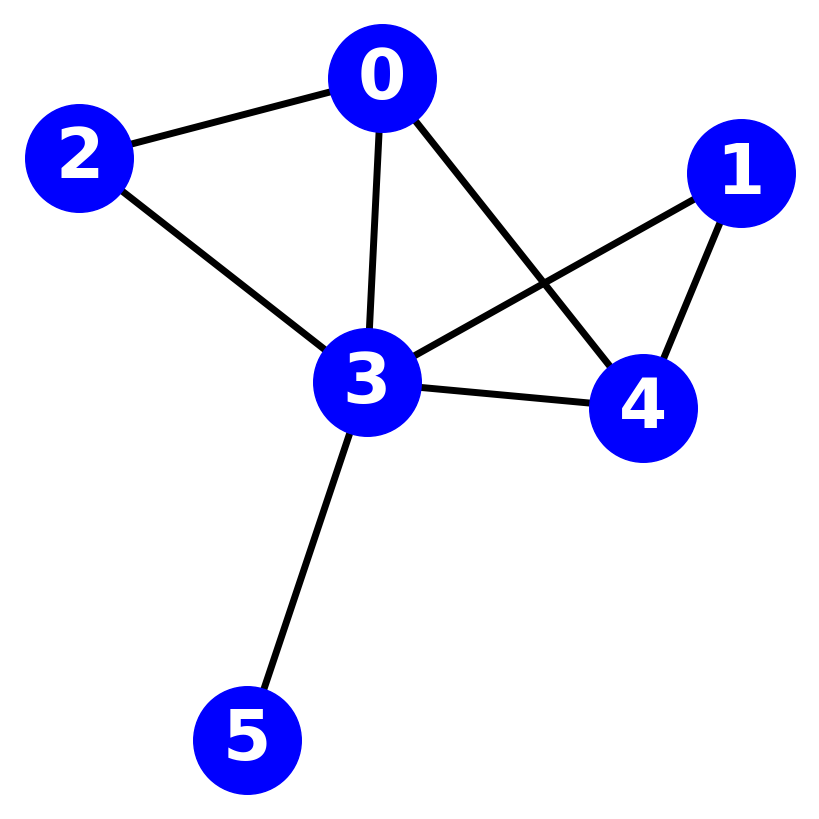

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

# plot a random network with 6 nodes and 10 edges
G = nx.gnm_random_graph(6, 8)

# plot
plt.figure(figsize=(8,8),dpi=100)

# nx.draw(G, with_labels=True, node_size=1000, pos=pos, node_color='blue', font_size=20, font_color='white', font_weight='bold')
nx.draw_kamada_kawai(G, with_labels=True, node_size=6000, node_color='blue', font_size=50, font_color='white', font_weight='bold',width=5)

In [6]:
# degree centrality
print(nx.degree_centrality(G))
# betweenness centrality
print(nx.betweenness_centrality(G))
# closeness centrality
print(nx.closeness_centrality(G))
# eigenvector centrality
print(nx.eigenvector_centrality(G))


{0: 0.6000000000000001, 1: 0.4, 2: 0.4, 3: 1.0, 4: 0.6000000000000001, 5: 0.2}
{0: 0.05, 1: 0.0, 2: 0.0, 3: 0.6000000000000001, 4: 0.05, 5: 0.0}
{0: 0.7142857142857143, 1: 0.625, 2: 0.625, 3: 1.0, 4: 0.7142857142857143, 5: 0.5555555555555556}
{0: 0.44811914193156177, 1: 0.3373012105609779, 2: 0.3373012105609779, 3: 0.5785375120614861, 4: 0.44811914193156177, 5: 0.19007525645108347}


In [4]:
2/5

0.4

In [82]:
# get adjacency matrix
import numpy as np
import array_to_latex as a2l

A = nx.adjacency_matrix(G)
A = A.todense()
A=np.array(A).astype(int)

a2l.to_ltx(A,)

\begin{bmatrix}
  0.00 &  1.00 &  0.00 &  1.00 &  0.00 &  1.00\\
  1.00 &  0.00 &  0.00 &  0.00 &  0.00 &  1.00\\
  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  1.00\\
  1.00 &  0.00 &  0.00 &  0.00 &  1.00 &  1.00\\
  0.00 &  0.00 &  0.00 &  1.00 &  0.00 &  1.00\\
  1.00 &  1.00 &  1.00 &  1.00 &  1.00 &  0.00
\end{bmatrix}


/tmp/ipykernel_8604/1749524696.py:5: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


$$A=\begin{bmatrix}
  0.00 &  1.00 &  0.00 &  1.00 &  0.00 &  1.00\\
  1.00 &  0.00 &  0.00 &  0.00 &  0.00 &  1.00\\
  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  1.00\\
  1.00 &  0.00 &  0.00 &  0.00 &  1.00 &  1.00\\
  0.00 &  0.00 &  0.00 &  1.00 &  0.00 &  1.00\\
  1.00 &  1.00 &  1.00 &  1.00 &  1.00 &  0.00
\end{bmatrix}$$

In [1]:
import networkx as nx

# reaf gpickle
G = nx.read_gpickle('/home/pelle/Master_Thesis/data/external/test.gpickle')

In [2]:
len(G.nodes())

1081637

In [6]:
import praw
from time import sleep
from tqdm import tqdm
import pandas as pd

# Read-only instance
def get_reddit_instance():
    reddit = praw.Reddit(client_id="OlWj7Mu4aXh0eg",
                                client_secret="fIzRhpEeBYAwi8_i2hcyzoWwDnWOag",
                                user_agent="Scrapper")
    return reddit

In [7]:
sample = pd.read_csv('/home/pelle/Downloads/submissions_pmaw_2016-2021_wsb.csv',nrows=10)
dtypes = sample.dtypes # Get the dtypes
cols = sample.columns # Get the columns
dtype_dictionary = {} 
for c in cols:
    if str(dtypes[c]) == 'int64':
        dtype_dictionary[c] = 'float32' # Handle NANs in int columns
    else:
        dtype_dictionary[c] = str(dtypes[c])

df_posts = pd.read_csv('/home/pelle/Downloads/submissions_pmaw_2016-2021_wsb.csv',dtype=dtype_dictionary, 
                keep_default_na=False,
                na_values=['na',''],
                usecols=['author','created_utc','score','id'])
df_posts.created_utc = pd.to_datetime(df_posts.created_utc,unit='s')

In [49]:
df_posts=df_posts.loc[df_posts.author == 'DeepFuckingValue']

In [43]:
# get amount of awards for each submission
N_awards = [len(x) for x in submission_awards]
print(N_awards)

[7, 10, 30, 37, 22, 26, 50, 28, 48, 44, 80, 89, 7, 7, 8, 13, 7, 5, 9, 6, 13, 6, 9, 7, 11, 7, 7, 8, 8, 0, 9, 33, 17, 6, 9, 10, 9, 23, 10, 8, 8, 9, 11, 25, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [55]:
submission_awards = []

submission = reddit.submission(id='gb3ctb')
submission_awards.append(submission.all_awardings)
# get number of awards
N_awards = [len(x) for x in submission_awards]
# submission_awards
print(N_awards[0])

7


In [57]:
import datetime
path='/home/pelle/Master_Thesis/data/raw/DTU_2015-01-01-2022-01-01/DTU_posts.csv'

def read_posts(path):
    df=pd.read_csv(path)
    df.columns = ['author','created_utc','domain','id','n_comments','score','text','title','url','date']
    df['date'] = pd.to_datetime(df['date'],unit='s')
    # drop floats in date column
    df = df[df['date'].apply(lambda x: isinstance(x, datetime.datetime))]
    df['author'].dropna(inplace=True)
    df.drop(df.loc[df['author']=='[deleted]'].index, inplace=True)
    return df

df=read_posts(path)


reddit = get_reddit_instance()

def get_n_awards(id):
    submission_awards = []
    submission = reddit.submission(id=id)
    submission_awards.append(submission.all_awardings)
    # get number of awards
    return [len(x) for x in submission_awards]

df['N_awards']=df['id'].apply(lambda x: get_n_awards(x))

In [69]:
import analysis_util
subreddit='DTU'

path_post='/home/pelle/Master_Thesis/data/raw/DTU_2015-01-01-2022-01-01' +'/'+ subreddit + "_posts.csv"
path_comment = '/home/pelle/Master_Thesis/data/raw/DTU_2015-01-01-2022-01-01' +'/'+ subreddit + "_comments.csv"

df_comments=analysis_util.read_comments(path_comment)
df_post=analysis_util.read_posts(path_post)
df_all_nodes=analysis_util.get_all_nodes(df_post,df_comments)

G_di = analysis_util.get_DiGraph(df_post,df_comments,df_all_nodes)
G=analysis_util.get_graph(df_post,df_comments,df_all_nodes)
G_big=analysis_util.get_biggest_component(G)

df_comment_post = analysis_util.get_comment_post_date(df_comments,df_post)
df_authors = analysis_util.get_authors(G,df_all_nodes,df_comments,df_post,df_comment_post)

Removed 0.02263374485596703 of the rows


In [67]:
df.loc[df.N_awards=0]

,author,created_utc,domain,id,n_comments,score,text,title,url,date,N_awards
223,LeCyberDucky,1595510544,self.DTU,hwfjpa,12,22,"Hey everybody,\n\nthis sub was restricted a wh...",We're back!,https://www.reddit.com/r/DTU/comments/hwfjpa/w...,2020-07-23 11:22:24,2
377,LeCyberDucky,1627552056,self.DTU,otucws,4,1,[Study announcement s1844: Registration for th...,[Reminder] Sign up for courses in the fall sem...,https://www.reddit.com/r/DTU/comments/otucws/r...,2021-07-29 07:47:36,1
496,_l______________l_,1641040072,i.redd.it,rtihvg,0,1,NaN,DTU by night,https://i.redd.it/1rgqodz4l2981.jpg,2022-01-01 10:27:52,1


In [98]:
df_authors['sum_awards']=df_authors['index'].apply(lambda x: df.loc[df.author==x]['N_awards'].sum())
df_authors['mean_awards']=df_authors['index'].apply(lambda x: df.loc[df.author==x]['N_awards'].mean())

df_authors

,level_0,index,Activity,Degree Centrality,Betweenness Centrality,degree,type,mean_score,sum_score,sum_awards,mean_awards
0,92,LeCyberDucky,96,0.100291,0.265163,69,both,2.020833,194,3,0.5
1,224,tom2hybrid,63,0.061047,0.111640,42,both,1.555556,98,0,0.0
2,169,Asrial,34,0.036337,0.038605,25,commenter,1.941176,66,0,NaN
3,267,roberts_the_mcrobert,44,0.045058,0.066449,31,commenter,1.477273,65,0,NaN
4,679,[deleted],64,0.074128,0.173443,51,commenter,0.968750,62,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
570,418,akajolicoeur,1,0.001453,0.000000,1,commenter,1.000000,1,0,NaN
685,685,nbkwprqyeag,1,0.000000,0.000000,0,poster,0.000000,0,0,0.0
686,686,ajindi,1,0.000000,0.000000,0,poster,0.000000,0,0,0.0
687,688,converter-bot,1,0.002907,0.000027,2,commenter,-2.000000,-2,0,NaN


In [38]:
df_comments

NameError: name 'df_comments' is not defined

In [40]:
import praw
import datetime
from tqdm import tqdm
tqdm.pandas()

# Read-only instance
def get_reddit_instance():
    reddit = praw.Reddit(client_id="OlWj7Mu4aXh0eg",
                                client_secret="fIzRhpEeBYAwi8_i2hcyzoWwDnWOag",
                                user_agent="Scrapper")
    return reddit


def get_n_awards(id):
    submission_awards = []
    submission = reddit.comment(id=id)
    submission_awards.append(submission.all_awardings)
    # get number of awards
    return submission.all_awardings

reddit = get_reddit_instance()
print(len(get_n_awards('cnd4yxb')))

0
